In [1]:
from mesh_library import *

In [2]:
mesh = mesh_gen_uniform_2D_grid(4,3, "triangle")

In [3]:
meshio.write("mesh.msh", mesh, file_format="gmsh22")

In [4]:
mesh.cell_data

{'gmsh:physical': [array([1, 1, 1, 2, 2, 2, 3, 3, 4, 4]),
  array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6])],
 'gmsh:geometrical': [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])]}

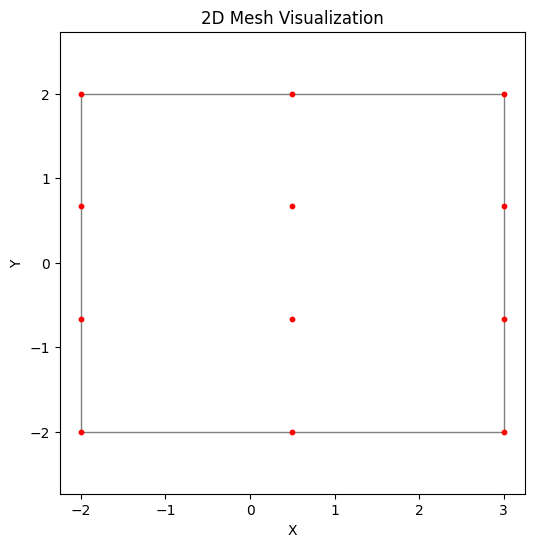

In [5]:
plot_mesh(mesh)

In [6]:
def project_vector(v: np.ndarray, u: np.ndarray) -> np.ndarray:
    """
    Projects vector v onto vector u in the plane.
    
    Parameters:
        v (np.ndarray): The vector to be projected.
        u (np.ndarray): The vector onto which v is projected.
        
    Returns:
        np.ndarray: The projection of v onto u.
    """
    u_dot_u = np.dot(u, u)  # Squared magnitude of u
    if u_dot_u == 0:
        raise ValueError("Cannot project onto a zero vector.")
    
    projection = (np.dot(v, u) / u_dot_u) * u
    return projection

In [ ]:
def find_point_on_boundary(point : np.ndarray, BP1 : np.ndarray, BP2 : np.ndarray) -> np.ndarray:
    BP_vec = BP2 - BP1
    point_vec = point - BP1
    projected_point_vec = project_vector(point_vec, BP_vec)
    orthogornal_vec = point_vec - projected_point_vec
    a = (projected_point_vec/BP_vec)[0]
    # if point is on the front half of the NACA airfoil
    if a < 0:
        y_sign = np.sign(point[1] - BP1[1])
        x_sign = np.sign(point[0] - BP1[0])
        if y_sign != 0 and x_sign != 0:
            b = ((2*y_sign - point)/point_vec[1])[0]
            if -3 < b*point_vec[0] < 3:
                return point + point_vec*b
            c = ((3*x_sign - point)/point_vec[0])[0]
            return point + orthogornal_vec*c
        if y_sign == 0:
            return np.array([x_sign*3, point[1]])
        if x_sign == 0:
            return np.array([point[0], y_sign*2])
    # if point is on the back part of the NACA airfoil
    if a > 1:
        point_vec = point - BP2
        y_sign = np.sign(point[1] - BP1[1])
        x_sign = np.sign(point[0] - BP1[0])
        if y_sign != 0 and x_sign != 0:
            b = ((2*y_sign - point)/point_vec[1])[0]
            if -3 < b*point_vec[0] < 3:
                return point + point_vec*b
            c = ((3*x_sign - point)/point_vec[0])[0]
            return point + orthogornal_vec*c
        if y_sign == 0:
            return np.array([x_sign*3, point[1]])
        if x_sign == 0:
            return np.array([point[0], y_sign*2])
    

    # if point is between the brændpunkter
    if orthogornal_vec[1] > 0:
        b = ((2 - point)/orthogornal_vec[1])[0]
        if b*orthogornal_vec[0] < 3:
            return point + orthogornal_vec*b 
        c = ((3 - point)/orthogornal_vec[0])[0]
        return point + orthogornal_vec*c
    b = ((-2 - point)/orthogornal_vec[1])[0]
    print(b)
    if b*orthogornal_vec[0] < 3:
        return point + orthogornal_vec*b 
    c = ((-3 - point)/orthogornal_vec[0])[0]
    return point + orthogornal_vec*c

In [77]:
def transfinite_line(N : int, p1 : np.ndarray, p2 : np.ndarray, func : callable = lambda x: x) -> np.ndarray:
    """
    Generates a line from p1 to p2 with N points, where the spacing between points
    is dictated by the function `func`.
    
    Parameters:
        N (int): Number of points including p1 and p2.
        p1 (np.ndarray): Start point in the plane (2D or 3D).
        p2 (np.ndarray): End point in the plane (2D or 3D).
        func (callable): Function that defines the spacing transformation. 
                         It should take a parameter in [0, 1] and return a value in [0, 1].

    Returns:
        np.ndarray: An array of shape (N, dim) containing the generated points.
    """
    p1, p2 = np.array(p1), np.array(p2)
    assert p1.shape == p2.shape, "p1 and p2 must have the same dimensions"
    
    # Generate uniform parameter values in [0,1]
    s_uniform = np.linspace(0, 1, N+1)
    
    # Apply transformation function
    s_transformed = np.array([func(s) for s in s_uniform])
    
    # Normalize transformed values to stay in [0,1] range
    s_transformed = (s_transformed - s_transformed[0]) / (s_transformed[-1] - s_transformed[0])
    
    # Compute interpolated points
    points = (1 - s_transformed)[:, None] * p1 + s_transformed[:, None] * p2
    
    return points[1:,:]

In [78]:
def NACA_mesh(points_on_airfoil : int, points_towards_airfoil : int, NACA_name : str, angle_of_attack : float = 0, func : callable = lambda x : x, BP1 : np.ndarray = np.array([-0.1,0]), BP2 : np.ndarray = np.array([0.1,0])) -> meshio.Mesh:
    try:
        NACA_points = np.loadtxt(f"NACA_{NACA_name}.txt")
    except:
        raise ValueError("The data for this NACA-airfoil is not in the directory")
    # Defining points
    NACA_points = NACA_points[::(200//points_on_airfoil),:]
    NACA_points = NACA_points - np.array([0.5,0])
    angle_of_attack_rad = angle_of_attack*np.pi/180
    rot_mat = np.array([
        [np.cos(angle_of_attack_rad), -np.sin(angle_of_attack_rad)],
        [np.sin(angle_of_attack_rad), np.cos(angle_of_attack_rad)]
    ])
    NACA_points = (NACA_points)@rot_mat

    BP1 = rot_mat@BP1
    BP2 = rot_mat@BP2
    for i in range(len(NACA_points)):
        p1 = NACA_points[i]
        p2 = find_point_on_boundary(p1, BP1, BP2)
        NACA_points = np.vstack([NACA_points,transfinite_line(points_towards_airfoil, p1, p2, func)])

    final_points = np.append(NACA_points, np.zeros((NACA_points.shape[0],1)), axis=1)

    # Defining cells
    cells = [("polygon", list(range(points_on_airfoil+1)))]  # Airfoil as a mesh

    return meshio.Mesh(points=final_points, cells=cells)

HEJ
[-0.154508  0.074468]
[0.2 0. ]
[-0.054508  0.074468]
[-0.054508 -0.      ]
-0.27253999999999984
HEJ
[-0.293893  0.072143]
[0.2 0. ]
[-0.193893  0.072143]
[-0.193893 -0.      ]
-0.9694649999999997
HEJ
[-0.404508  0.057561]
[0.2 0. ]
[-0.304508  0.057561]
[-0.304508 -0.      ]
-1.52254
HEJ
[-0.475528  0.032367]
[0.2 0. ]
[-0.375528  0.032367]
[-0.375528 -0.      ]
-1.8776399999999995
HEJ
[-0.5  0. ]
[0.2 0. ]
[-0.4  0. ]
[-0.4 -0. ]
-2.0
HEJ
[-0.475528 -0.032367]
[0.2 0. ]
[-0.375528 -0.032367]
[-0.375528 -0.      ]
-1.8776399999999995
HEJ
[-0.404508 -0.057561]
[0.2 0. ]
[-0.304508 -0.057561]
[-0.304508 -0.      ]
-1.52254
HEJ
[-0.293893 -0.072143]
[0.2 0. ]
[-0.193893 -0.072143]
[-0.193893 -0.      ]
-0.9694649999999997
HEJ
[-0.154508 -0.074468]
[0.2 0. ]
[-0.054508 -0.074468]
[-0.054508 -0.      ]
-0.27253999999999984
30.22289384208538


/var/folders/88/1197_r253tbcstwj4b_1zlf80000gn/T/ipykernel_43086/2032677478.py:6: RuntimeWarning: invalid value encountered in divide
  a = (projected_point_vec/BP_vec)[0]


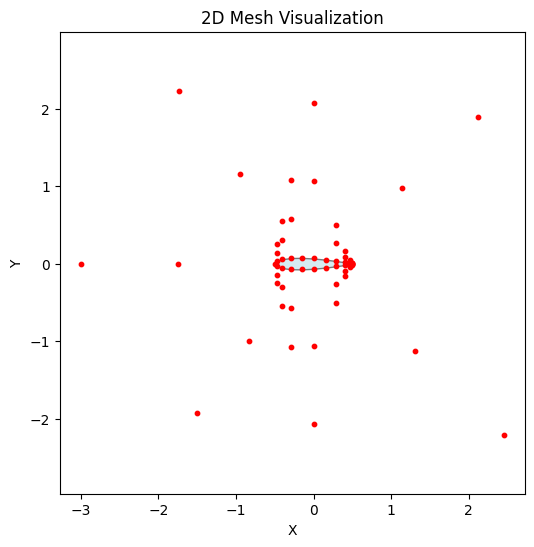

In [79]:
plot_mesh(NACA_mesh(20,2,"0015"))

In [74]:
np.tile(np.array([[1,2]]),4)

array([[1, 2, 1, 2, 1, 2, 1, 2]])